In [54]:
import numpy as np
import pandas as pd
import os
import cv2
import time
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
#import tensorflow.keras.backend as K
import tensorflow.compat.v1.keras.backend as K
from src.dnn_testing.eAI.utils import validate_utils_cost as validate_utils
from tensorflow import keras
%matplotlib inline

In [55]:
 # Helper function
# Print markdown style
def printmd(string):
    display(Markdown(string))
    
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [58]:
TRAINING_PATH = '../nii_dataset/training/LFW/'
DATA_PATH = '../nii_dataset/LFW/'
EXP_PATH = '../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/'

In [59]:
from src.dnn_testing.eAI.utils import data_util
from pathlib import Path

In [60]:
filepath = TRAINING_PATH+'VGG-Gender.h5'
#filepath = TRAINING_PATH+"LetNet5-gender-lfw.h5"
batch_size = 32
num_runs = 30
Exp_name = 'Exp-repair-vgg16-v1'
#Exp_name = 'Exp-repair-LeNet5-v1'
model_dir = filepath
FAIRNESS = 'FPR'
unfav = 1
based_on = 5
topN = 8
random_seed = 42
sample_global = False
INCLUDE_POSITIVE = False
EXP_TYPE = 'None'
SAMPLE_TYPE = 0
data_dir = Path(EXP_PATH+'{}'.format(Exp_name))
data_sampled_dir = Path(EXP_PATH+'{}/sampled'.format(Exp_name))

In [61]:
if not Path.exists(data_dir):
    Path.mkdir(data_dir, exist_ok=True, parents=True)
if not Path.exists(data_sampled_dir):
    Path.mkdir(data_sampled_dir, exist_ok=True, parents=True)

In [62]:
#test_images, test_labels = data_util.load_dataset_from_hdf(Path('../nii_dataset/experiments/eAI/LFW/'), "test.h5")
#test_images, test_age, test_labels, test_race = data_util.load_dataset_from_hdf_multiple_labels(Path(EXP_PATH), 'test_data.h5')
test_images, test_labels = data_util.load_dataset_from_hdf(Path(EXP_PATH), 'test.h5')

In [63]:
model = data_util.load_model_from_tf(Path(filepath))

In [64]:
results = model.predict(test_images, verbose=0, batch_size=batch_size)

In [65]:
successes, failures, data_all, _, _, _, _, _, _, _, _, _, _, _, _ = data_util._parse_test_results_both(test_images, test_labels, results,decision_boundary=0.1)

In [66]:
data_util._save_positive_results_with_indices(successes, data_dir, 'positive')
data_util._save_negative_results_with_indices(failures, data_dir, 'negative')
data_util._save_negative_results_with_indices(data_all, data_dir, 'data_both')

In [67]:
target_data_neg_dir = Path(EXP_PATH+'{}/negative'.format(Exp_name))
target_data_dir_both = Path(EXP_PATH+'{}/data_both'.format(Exp_name))
target_data_pos_dir = Path(EXP_PATH+'{}/positive'.format(Exp_name))

output_dir = Path(EXP_PATH+'{}/results-{}-{}/{}/{}'.format(Exp_name, SAMPLE_TYPE, EXP_TYPE, str(based_on), FAIRNESS))
output_eval_dir = Path(EXP_PATH + '{}/evaluation-{}-{}/{}/{}'.format(Exp_name, SAMPLE_TYPE, EXP_TYPE, str(based_on), FAIRNESS))

input_neg = data_util.load_repair_data(target_data_neg_dir)
input_pos = data_util.load_repair_data(target_data_pos_dir)
input_both = data_util.load_repair_data(target_data_dir_both)

print(input_neg[0].shape)
data_dict = {}
unfav, W_M, W_F, W_MC, W_MM, W_FC, W_FM, MC, MM, FC, FM = validate_utils._get_subgroup_names_as_binary(np.argmax(test_labels, axis=1), np.argmax(results, axis=1))
for i in range(num_runs):
    if SAMPLE_TYPE == 1:
        if not Path.exists(data_sampled_dir/'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i)):
            input_neg2, input_pos2, input_both2 = data_util._parse_results_sample_negative(test_images, test_labels, results, unfav)
            data_util.save_dataset_as_hdf_multiple_labels(input_neg2[0], [input_neg2[1], input_neg2[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i))
            data_util.save_dataset_as_hdf_multiple_labels(input_pos2[0], [input_pos2[1], input_pos2[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_pos_{}_{}.h5'.format(SAMPLE_TYPE, i))
            data_util.save_dataset_as_hdf_multiple_labels(input_both2[0], [input_both2[1], input_both2[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_both_{}_{}.h5'.format(SAMPLE_TYPE, i))
            data_dict[i] = {'NEG':input_neg2, 'POS':input_pos2, 'BOTH':input_both2}
        else:
            ## todo: load neg
            input_neg2 = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i))
            ## todo: load pos
            input_pos2 = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_pos_{}_{}.h5'.format(SAMPLE_TYPE, i))
            ## todo: load both
            input_both2 = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_both_{}_{}.h5'.format(SAMPLE_TYPE, i))

            data_dict[i] = {'NEG':input_neg2, 'POS':input_pos2, 'BOTH':input_both2}
    else:
        if not Path.exists(data_sampled_dir/'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i)):
            input_pos_sampled, _ = data_util._sample_positive_inputs(input_pos, input_neg[0].shape[0])
            #sens_pos = test_race[input_pos_sampled[2]]
            #sensi_both_indices = np.hstack((input_neg[2].astype(int), input_pos_sampled[2].astype(int))) 
            sensi_both = np.vstack((np.argmax(input_neg[1], axis=1), np.argmax(input_pos_sampled[1], axis=1)))
            input_neg = (input_neg[0], input_neg[1], np.argmax(input_neg[1], axis=1))
            input_pos_sampled = (input_pos_sampled[0], input_pos_sampled[1], np.argmax(input_pos_sampled[1], axis=1))
            
            input_both_sampled = (np.vstack((input_neg[0], input_pos_sampled[0])), np.vstack((input_neg[1], input_pos_sampled[1])), sensi_both)
            data_util.save_dataset_as_hdf_multiple_labels(input_neg[0], [input_neg[1], input_neg[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i))
            data_util.save_dataset_as_hdf_multiple_labels(input_pos_sampled[0], [input_pos_sampled[1], input_pos_sampled[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_pos_{}_{}.h5'.format(SAMPLE_TYPE, i))
            data_util.save_dataset_as_hdf_multiple_labels(input_both_sampled[0], [input_both_sampled[1], input_both_sampled[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_both_{}_{}.h5'.format(SAMPLE_TYPE, i))
            
            data_dict[i] = {'NEG':input_neg, 'POS':input_pos_sampled, 'BOTH':input_both_sampled}
        else:
            ## todo: load neg
            input_neg = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_neg_{}_{}.h5'.format(SAMPLE_TYPE, i))
            ## todo: load pos
            input_pos_sampled = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_pos_{}_{}.h5'.format(SAMPLE_TYPE, i))
            ## todo: load both
            #sens_both = np.hstack((input_neg[2], input_pos_sampled[2]))
            #input_both_sampled = (np.vstack((input_neg[0], input_pos_sampled[0])), np.vstack((input_neg[1], input_pos_sampled[1])), sens_both)
            #data_util.save_dataset_as_hdf_multiple_labels(input_both_sampled[0], [input_both_sampled[1], input_both_sampled[2]], ['labels', 'sensitive'], data_sampled_dir/'sampled_both_{}_{}.h5'.format(SAMPLE_TYPE, i))
            
            input_both_sampled = data_util.load_dataset_from_hdf_images_labels_sensitive(data_sampled_dir, 'sampled_both_{}_{}.h5'.format(SAMPLE_TYPE, i))
            
            data_dict[i] = {'NEG':input_neg, 'POS':input_pos_sampled, 'BOTH':input_both_sampled}

(504, 32, 32, 3)


In [68]:
if not Path.exists(output_dir):
    Path.mkdir(output_dir, exist_ok=True, parents=True)
if not Path.exists(output_eval_dir):
    Path.mkdir(output_eval_dir, exist_ok=True, parents=True)

In [69]:
from src.dnn_testing.eAI.utils.arachne_fairness_mixed import FairArachne2, EvaluateFairness

In [70]:
arachne = FairArachne2()

(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 399680.56it/s]

Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/weights.csv


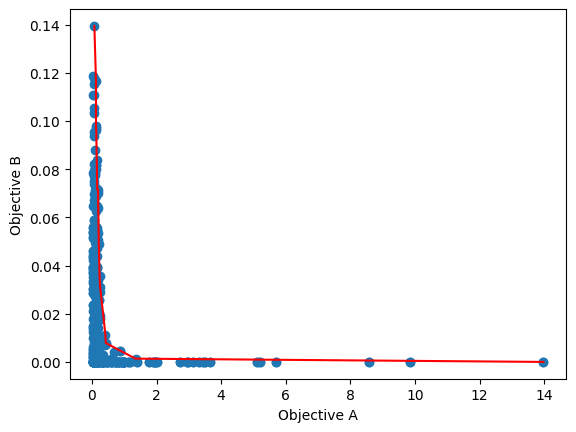

In [71]:
weights_t = arachne.localize_bias(model_dir,data_dict[0]['NEG'], data_dict[0]['POS'], data_dict[0]['BOTH'], output_dir, unfav=unfav, sample_global=False,based_on=based_on, topN=topN)

In [72]:
evaluateFairness = EvaluateFairness(model_dir, target_data_neg_dir,data_dict,test_labels, target_data_pos_dir, output_dir)
evaluateFairness.evaluate(num_runs,FAIRNESS, unfav, sample_global, based_on, start_iteration=0, topN=topN)
# evaluateFairness.evaluate_arachne(num_runs,FAIRNESS, unfav, sample_global, based_on, start_iteration=0, topN=topN)

0 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 362628.11it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_0/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_0/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_0/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_0/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_0/weights.csv
1 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 447485.65it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_1/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_1/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_1/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_1/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_1/weights.csv
2 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 374582.88it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_2/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_2/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_2/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_2/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_2/weights.csv
3 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 374517.55it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_3/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_3/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_3/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_3/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_3/weights.csv
4 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 328261.03it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_4/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_4/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_4/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_4/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_4/weights.csv
5 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 388473.89it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_5/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_5/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_5/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_5/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_5/weights.csv
6 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 392664.77it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_6/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_6/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_6/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_6/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_6/weights.csv
7 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 403131.90it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_7/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_7/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_7/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_7/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_7/weights.csv
8 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 396360.95it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_8/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_8/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_8/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_8/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_8/weights.csv
9 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 360316.05it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_9/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_9/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_9/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_9/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_9/weights.csv
10 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 388825.57it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_10/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_10/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_10/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_10/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_10/weights.csv
11 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 330942.16it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_11/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_11/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_11/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_11/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_11/weights.csv
12 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 420745.23it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_12/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_12/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_12/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_12/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_12/weights.csv
13 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 390238.71it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_13/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_13/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_13/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_13/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_13/weights.csv
14 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 377878.52it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_14/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_14/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_14/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_14/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_14/weights.csv
15 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 403738.23it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_15/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_15/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_15/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_15/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_15/weights.csv
16 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 356547.18it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_16/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_16/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_16/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_16/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_16/weights.csv
17 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 355308.35it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_17/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_17/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_17/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_17/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_17/weights.csv
18 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 400351.16it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_18/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_18/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_18/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_18/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_18/weights.csv
19 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 430185.03it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_19/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_19/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_19/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_19/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_19/weights.csv
20 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 409590.63it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_20/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_20/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_20/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_20/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_20/weights.csv
21 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 415534.76it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_21/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_21/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_21/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_21/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_21/weights.csv
22 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 386168.61it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_22/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_22/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_22/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_22/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_22/weights.csv
23 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 388473.89it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_23/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_23/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_23/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_23/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_23/weights.csv
24 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 328210.86it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_24/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_24/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_24/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_24/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_24/weights.csv
25 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 386933.99it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_25/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_25/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_25/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_25/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_25/weights.csv
26 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 382386.69it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_26/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_26/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_26/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_26/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_26/weights.csv
27 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 381165.01it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_27/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_27/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_27/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_27/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_27/weights.csv
28 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 367531.00it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_28/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_28/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_28/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_28/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_28/weights.csv
29 model path:  ../nii_dataset/training/LFW/VGG-Gender.h5
(504, 32, 32, 3) None None


Extracting pareto-front: 100%|██████████| 512/512 [00:00<00:00, 377281.03it/s]


Localize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_29/weights.csv


Updating particle positions (it=12/100): 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_29/repair/assets


INFO:tensorflow:Assets written to: ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_29/repair/assets


Optimize results
created files:
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/localized_data_29/weights.csv
     ../nii_dataset/experiments/eAI-fair-aware-mixed/LFW/Exp-repair-vgg16-v1/results-0-None/5/FPR/repaired_model_29/weights.csv
